## K-means clustering on the data
Unsupervised learning

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle

In [38]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans

In [39]:
import sys
import os
sys.path.append('../..')
from src.utils.directories import get_parent_directory

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [15]:
parent_dir = get_parent_directory()

In [16]:
all_pkl_path = (os.path.join(parent_dir, "data/processed/ml_ready/merged_all.pkl"))

with open(all_pkl_path, 'rb') as f:
    data = pickle.load(f)

### Variables needed for clustering
S, T, log_eps, log_N2, dTdz, dSdz

In [40]:
var_df = data [['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]

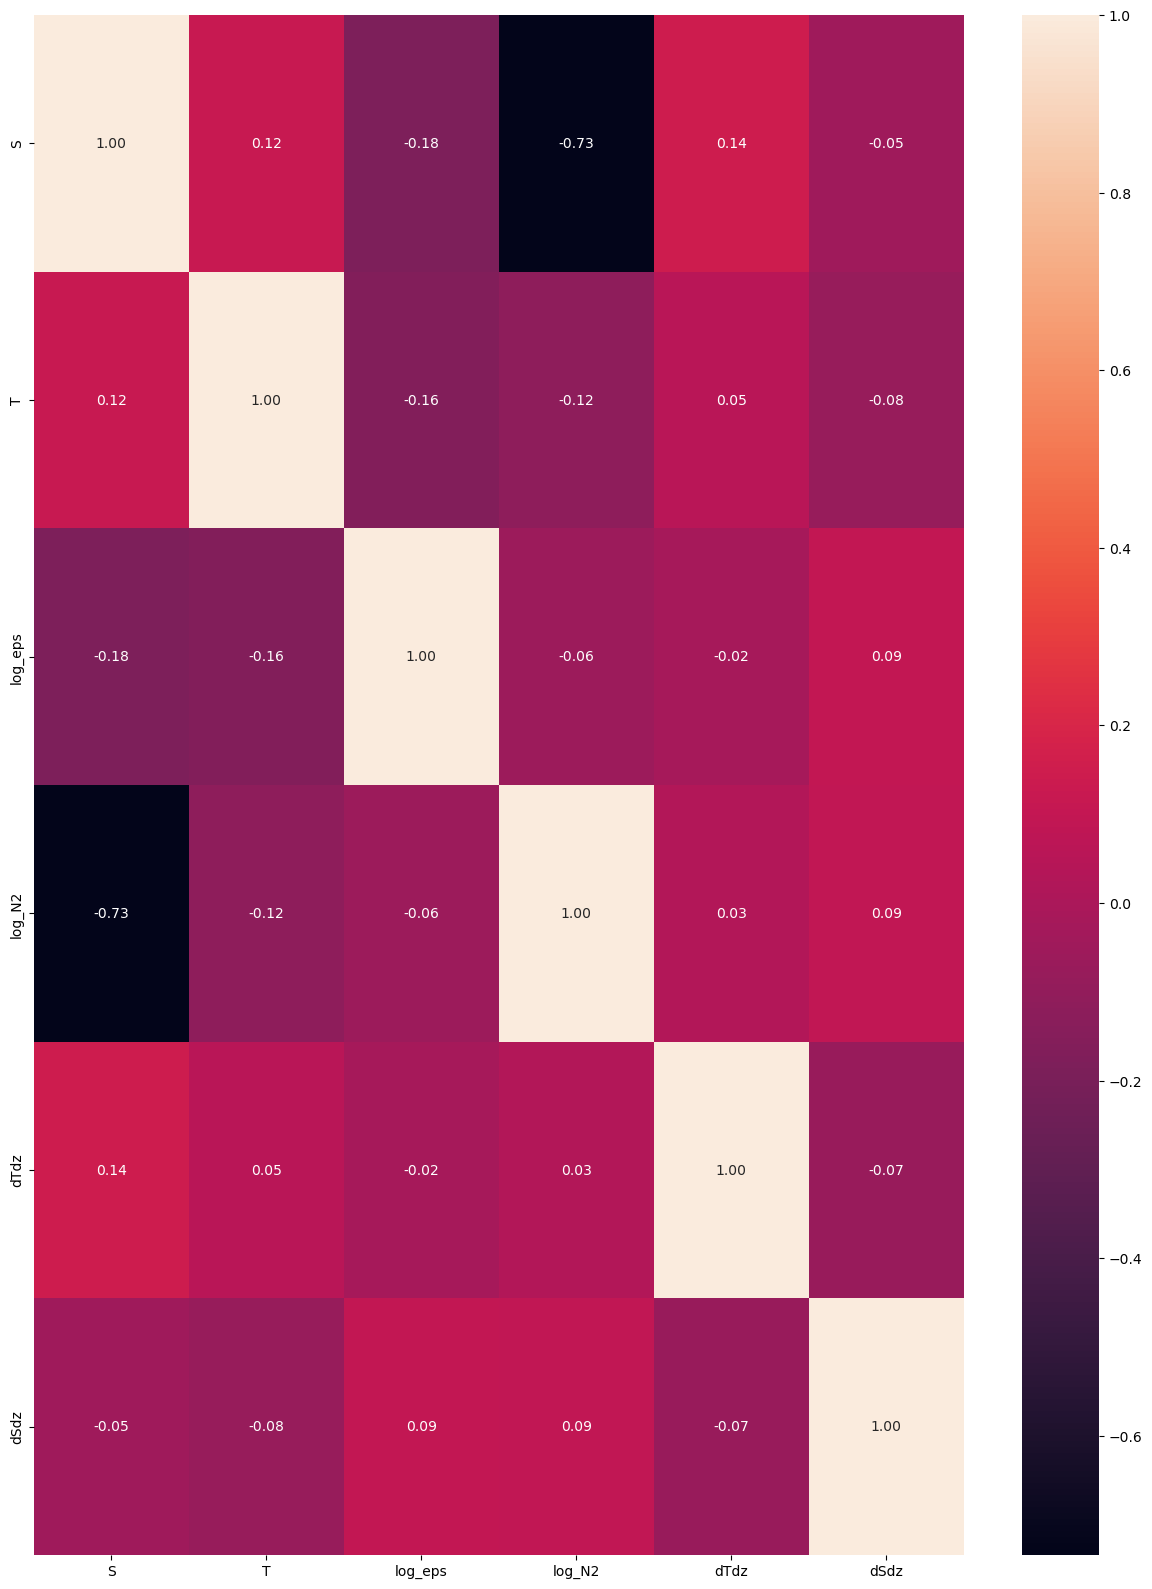

In [41]:
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation(data):
    rcParams['figure.figsize'] = 15, 20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()

# plot correlation & densities
plot_correlation(var_df)

## Scaling

In [42]:
# Keep the column names
column_names = var_df.columns

X = var_df

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add the column names back to the X_scaled array
X_scaled = pd.DataFrame(X_scaled, columns=column_names)

## Outlier detection

In [43]:
# Detect and handle outliers using Z-score method
from scipy import stats
z_scores = np.abs(stats.zscore(X_scaled))
threshold = 3  # Adjust the threshold as needed
outlier_indices = np.where(z_scores > threshold)
X_cleaned = X_scaled[(z_scores < threshold).all(axis=1)]

## K means

In [44]:
X = X_cleaned

In [45]:
# Initialize the K-means clustering model
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the K-means model to the data
kmeans.fit(X)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Elbow method: amount of clusters
look at within cluster variance

/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_in

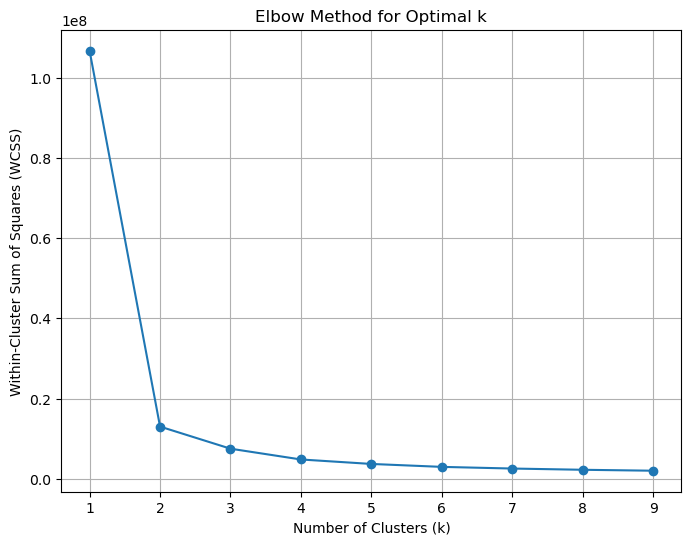

In [12]:
X = X_cleaned

# Initialize a list to store the within-cluster sum of squares (WCSS) values
wcss = []

# Specify a range of values for k (number of clusters)
k_values = range(1, 10)

# Calculate WCSS for different values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(var_df)
    wcss.append(kmeans.inertia_)

# Plot the elbow method curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

## Plot clusters

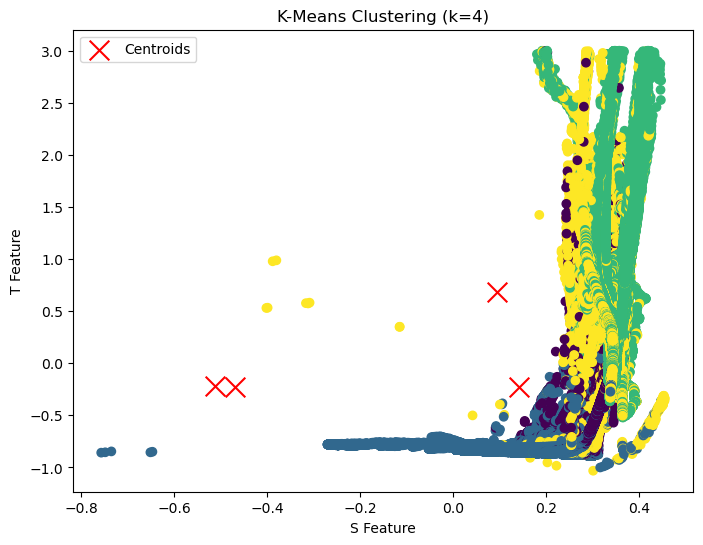

In [46]:
# Select the two features (S and T) for plotting
feature_s = X['S']
feature_t = X['T']

# Plot the data points with cluster assignments
plt.figure(figsize=(8, 6))
plt.scatter(feature_s, feature_t, c=cluster_labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 4], c='red', marker='x', s=200, label='Centroids')
plt.title(f'K-Means Clustering (k={k})')
plt.xlabel('S Feature')
plt.ylabel('T Feature')
plt.legend()
plt.show()

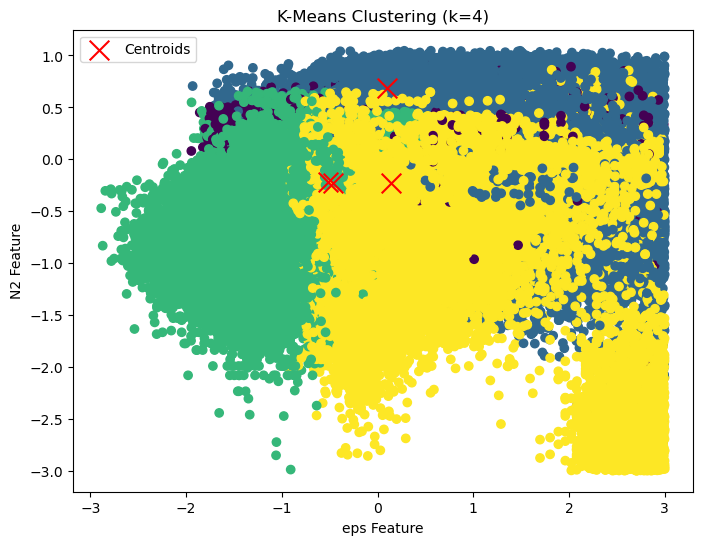

In [47]:
# Select the two features (eps and N2) for plotting
feature_e = X['log_eps']
feature_N = X['log_N2']

# Plot the data points with cluster assignments
plt.figure(figsize=(8, 6))
plt.scatter(feature_e, feature_N, c=cluster_labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 4], c='red', marker='x', s=200, label='Centroids')
plt.title(f'K-Means Clustering (k={k})')
plt.xlabel('eps Feature')
plt.ylabel('N2 Feature')
plt.legend()
plt.show()

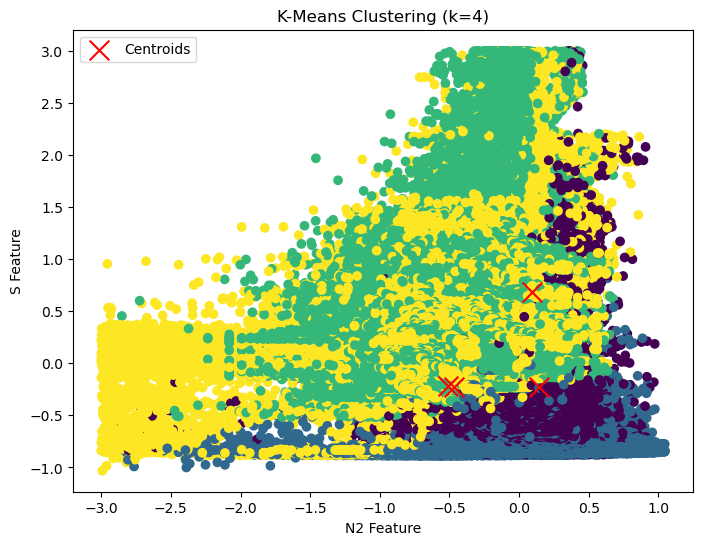

In [48]:
# Select the two features (N2 and T) for plotting
feature_N = X['log_N2']
feature_T = X['S']

# Plot the data points with cluster assignments
plt.figure(figsize=(8, 6))
plt.scatter(feature_N, feature_t, c=cluster_labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 4], c='red', marker='x', s=200, label='Centroids')
plt.title(f'K-Means Clustering (k={k})')
plt.xlabel('N2 Feature')
plt.ylabel('S Feature')
plt.legend()
plt.show()

## Spatial comparison

In [49]:
X_input = X[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]
# X_output = X[['Cluster']]

# Use the inverse_transform method to anti-scale X_scaled
transformed_df = pd.DataFrame(scaler.inverse_transform(X_input), columns=X_input.columns)
# Combine the inverse-transformed input features with the 'Cluster' column
# combined_df = transformed_df.assign(Cluster=X_output)
# Get cluster labels for each data point
# Add cluster labels to the DataFrame
transformed_df['Cluster'] = kmeans.labels_

In [50]:
# Round the values in the DataFrames to a specific number of decimal places
decimals = 4  # Adjust as needed
data_rounded = data.round(decimals)
transformed_df_rounded = transformed_df.round(decimals)

# Merge based on multiple columns (A and B)
merged_df = transformed_df_rounded.merge(data_rounded, on=['S', 'T', 'log_eps', 'log_N2', 'dSdz', 'dTdz'], how='left')

In [51]:
cluster_crisis_groups = merged_df.groupby(['Cluster', 'cruise']).size().unstack(fill_value=0)
print(cluster_crisis_groups)

cruise       1      2     3      4     5     6    7     8     9     10  ...  \
Cluster                                                                 ...   
0            0      0    32     93     6     1    0     2     0      0  ...   
1            1      1     3      0     0     0    0     0     0      0  ...   
2        25086  25721  1368  15384  5496  6058  917    12  7443  18181  ...   
3         4403  10033  1192    446  4602   703  671  2453   392    749  ...   

cruise   ABSO  ASCOS  Haakon Mosby  IPY Barneo 2007  IPY Barneo 2008  Mosaic  \
Cluster                                                                        
0           5  32769           787             6847            17005  133951   
1          17  45352            15             8623            22058  135253   
2           0    181          5799               16                1    2415   
3          88  21919          2775             9040            14429  115673   

cruise   NICE-2015  Nansen Legacy 2018  Nans

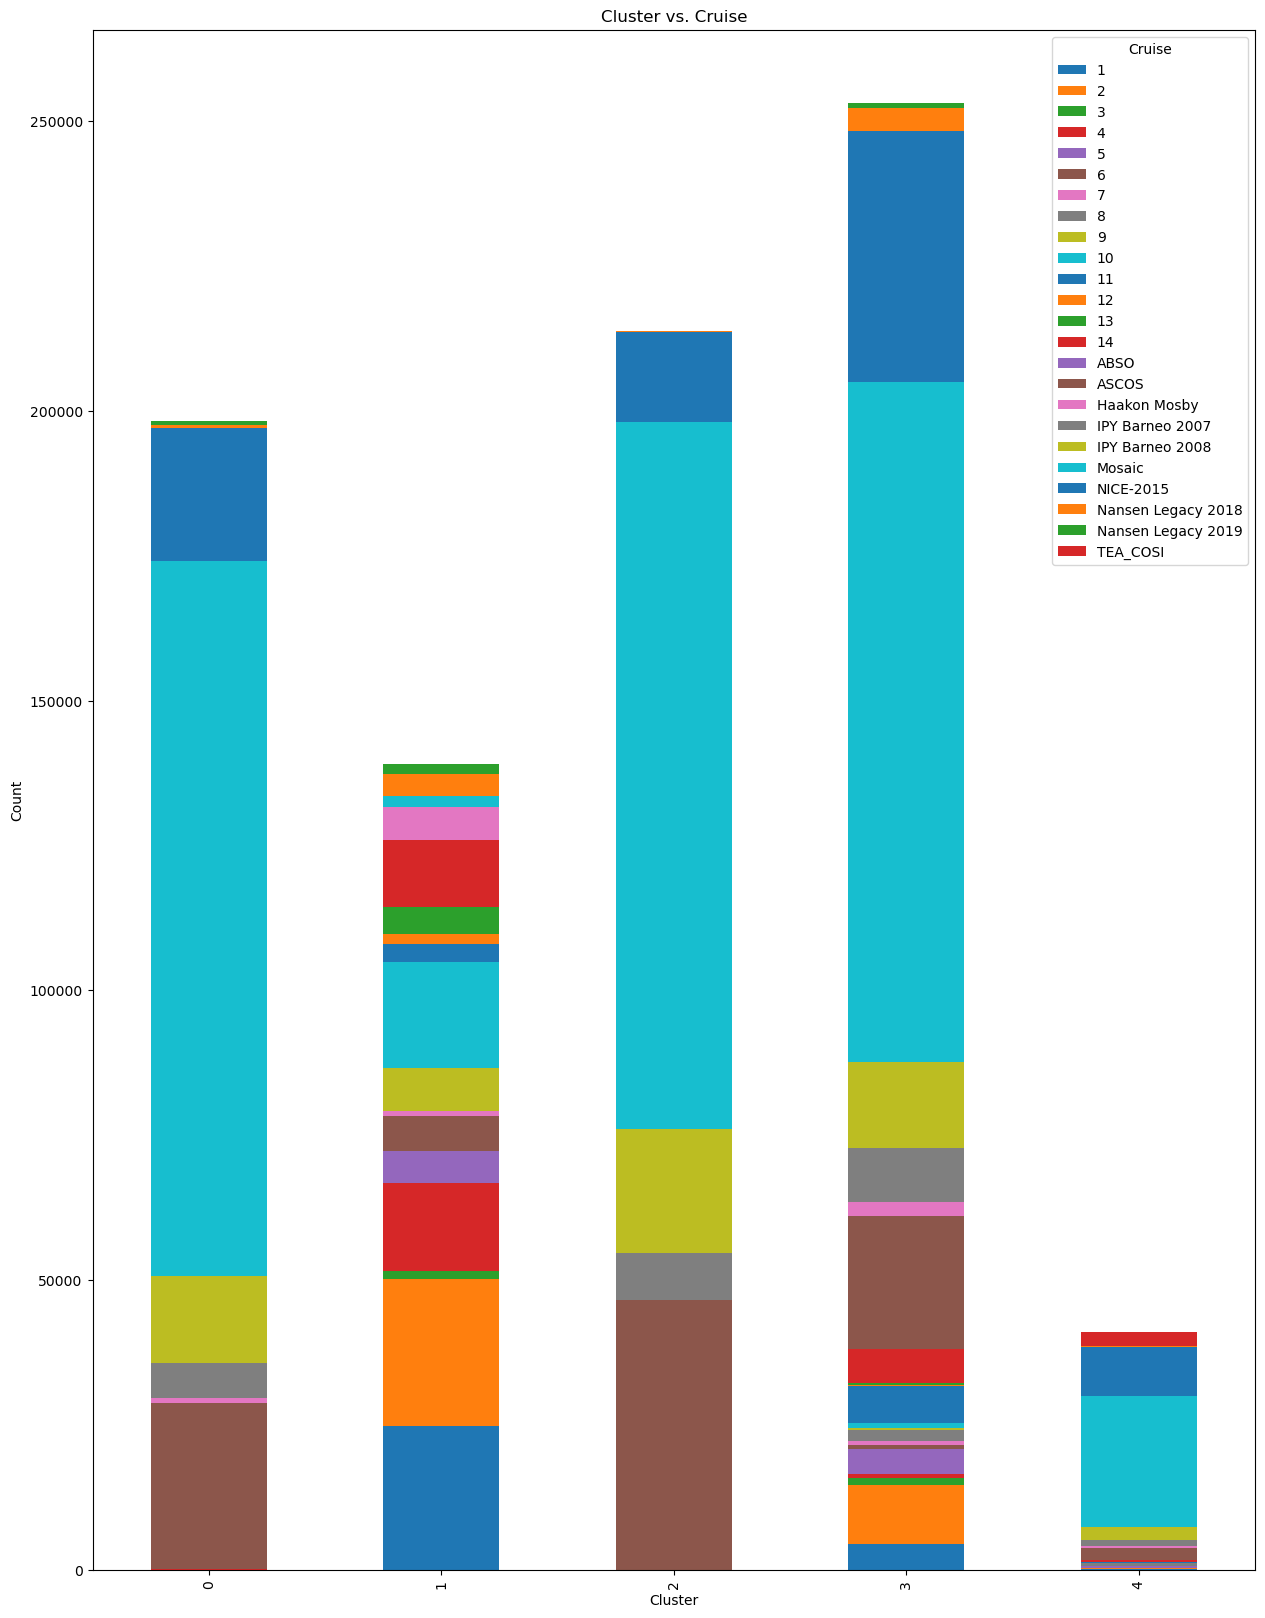

In [31]:
import matplotlib.pyplot as plt

# Bar plot for cluster vs. crisis
cluster_crisis_groups.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster vs. Cruise')
plt.legend(title='Cruise')
plt.show()

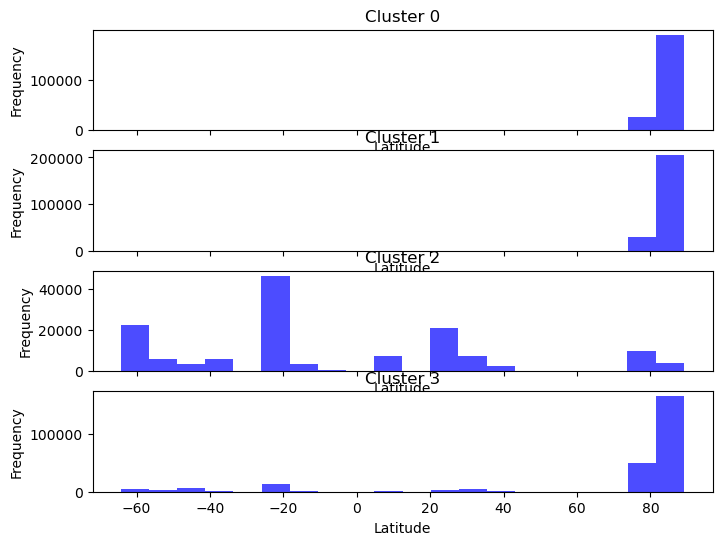

In [52]:
# Create a figure and axis for the histograms
fig, axes = plt.subplots(len(set(merged_df['Cluster'])), figsize=(8, 6), sharex=True)

for cluster_label, ax in zip(set(merged_df['Cluster']), axes):
    # Filter data points for the current cluster
    cluster_data = merged_df[merged_df['Cluster'] == cluster_label]
    
    # Plot a histogram of the latitude values for the current cluster
    ax.hist(cluster_data['latitude'], bins=20, alpha=0.7, color='blue')
    ax.set_title(f'Cluster {cluster_label}')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Frequency')

#plt.tight_layout()
plt.show()

## Analyse each cluster

In [54]:
# Analyse cluster 0
cluster_0_data = merged_df[merged_df['Cluster'] == 0]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)



                   S              T        log_eps         log_N2  \
count  215806.000000  215806.000000  215806.000000  215806.000000   
mean       34.507216       0.000535      -9.031454      -4.474571   
std         0.215457       1.023348       0.300635       0.336553   
min        32.270000      -1.864200     -10.750400     -10.432800   
25%        34.363400      -0.818800      -9.197300      -4.639600   
50%        34.504500      -0.067300      -9.061600      -4.451000   
75%        34.663400       0.716600      -8.900300      -4.274800   
max        35.144700      10.322300      -6.208600      -2.750700   

                dTdz           dSdz   Cluster          depth        profile  \
count  215806.000000  215806.000000  215806.0  215806.000000  215806.000000   
mean        0.033706       0.007122       0.0     152.577523     734.689563   
std         0.017162       0.004787       0.0     139.820838    2258.724071   
min         0.000100      -0.031000       0.0   -5443.000000  

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Example: Calculate feature importance using a Random Forest Classifier
cluster_0_data = cluster_0_data.dropna()
X = cluster_0_data.drop(['Cluster', 'cruise', 'longitude', 'latitude', 'profile', 'depth'], axis=1)
y = cluster_0_data['cruise']
clf = RandomForestClassifier()
clf.fit(X, y)
feature_importance = clf.feature_importances_

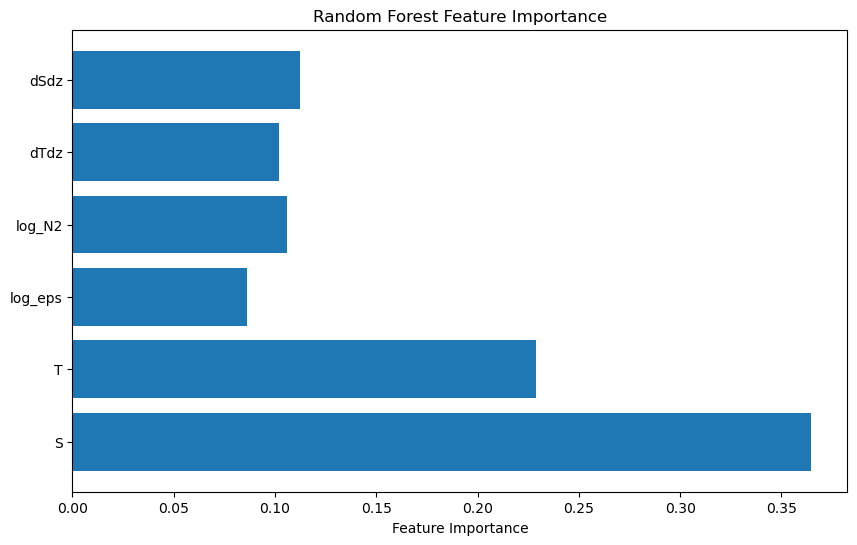

In [42]:
feature_names = X.columns

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), feature_importance, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

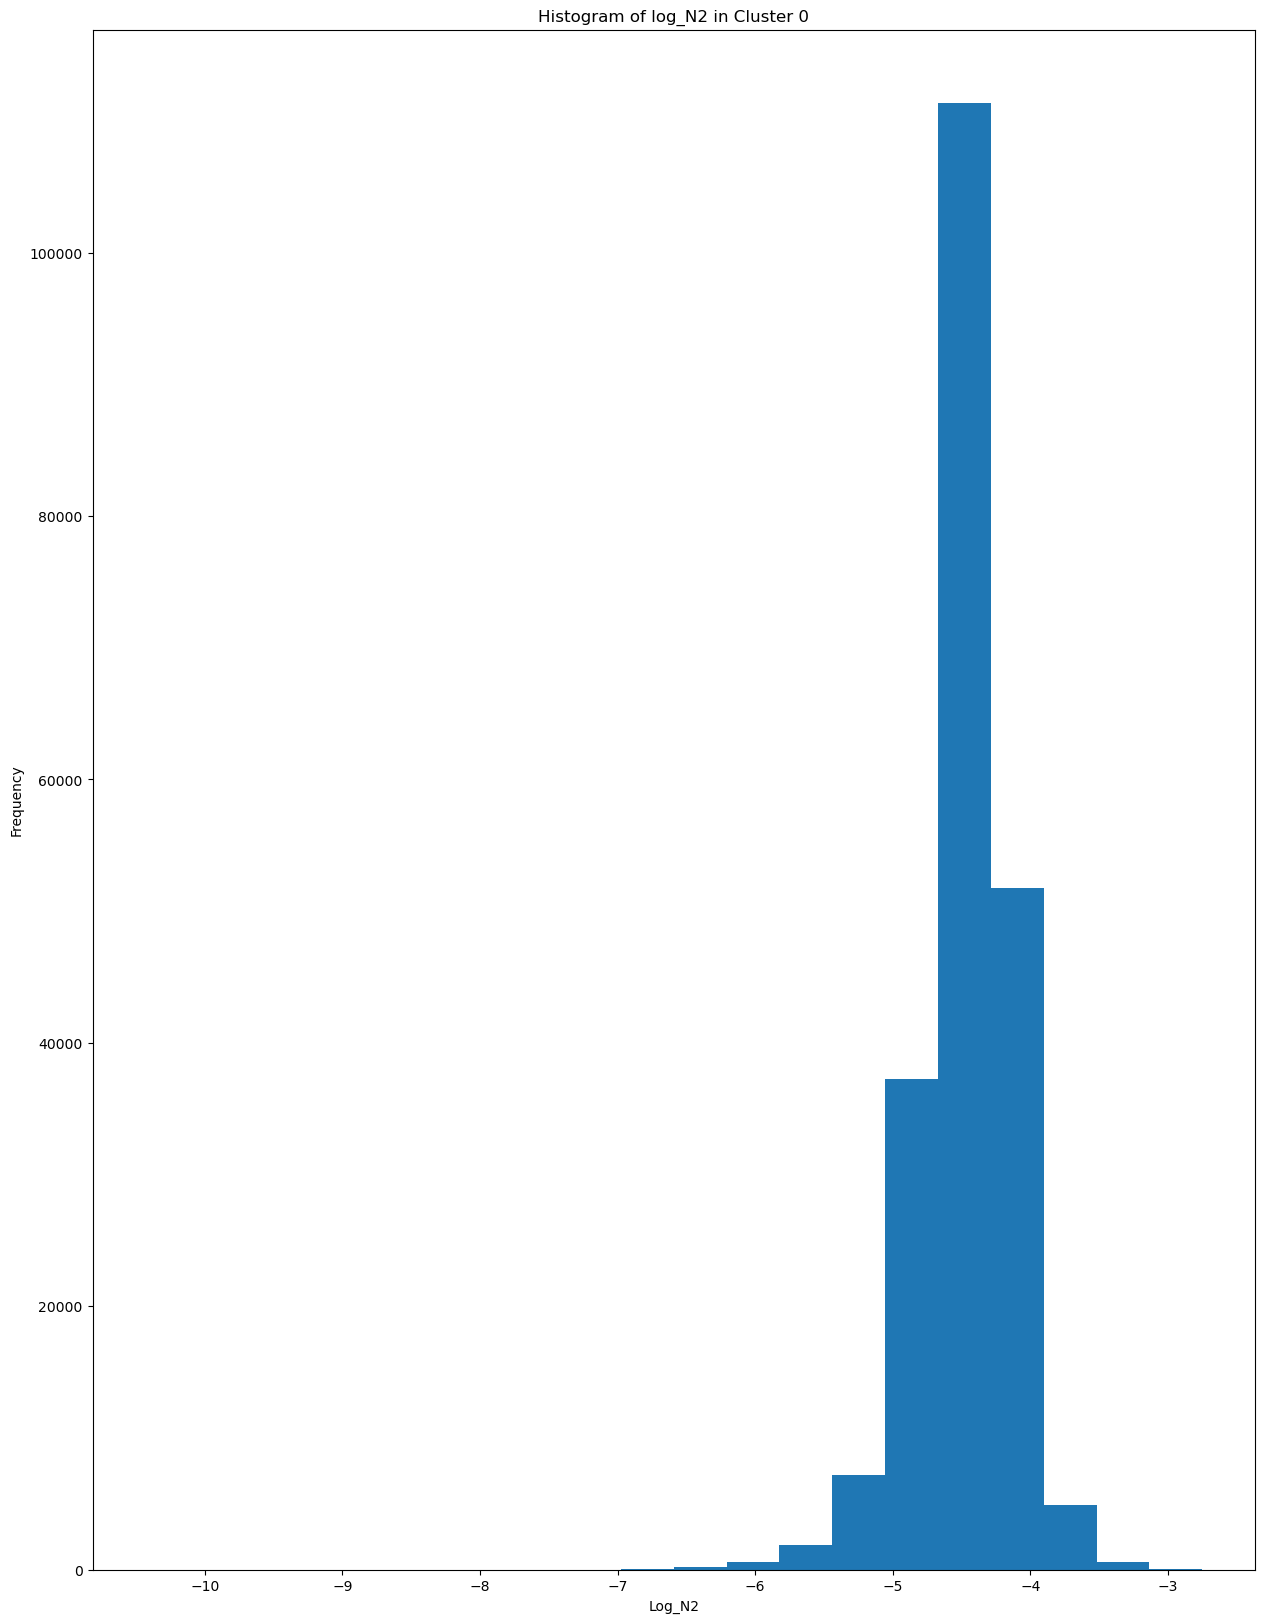

In [55]:
plt.hist(cluster_0_data['log_N2'], bins=20)
plt.xlabel('Log_N2')
plt.ylabel('Frequency')
plt.title('Histogram of log_N2 in Cluster 0')
plt.show()

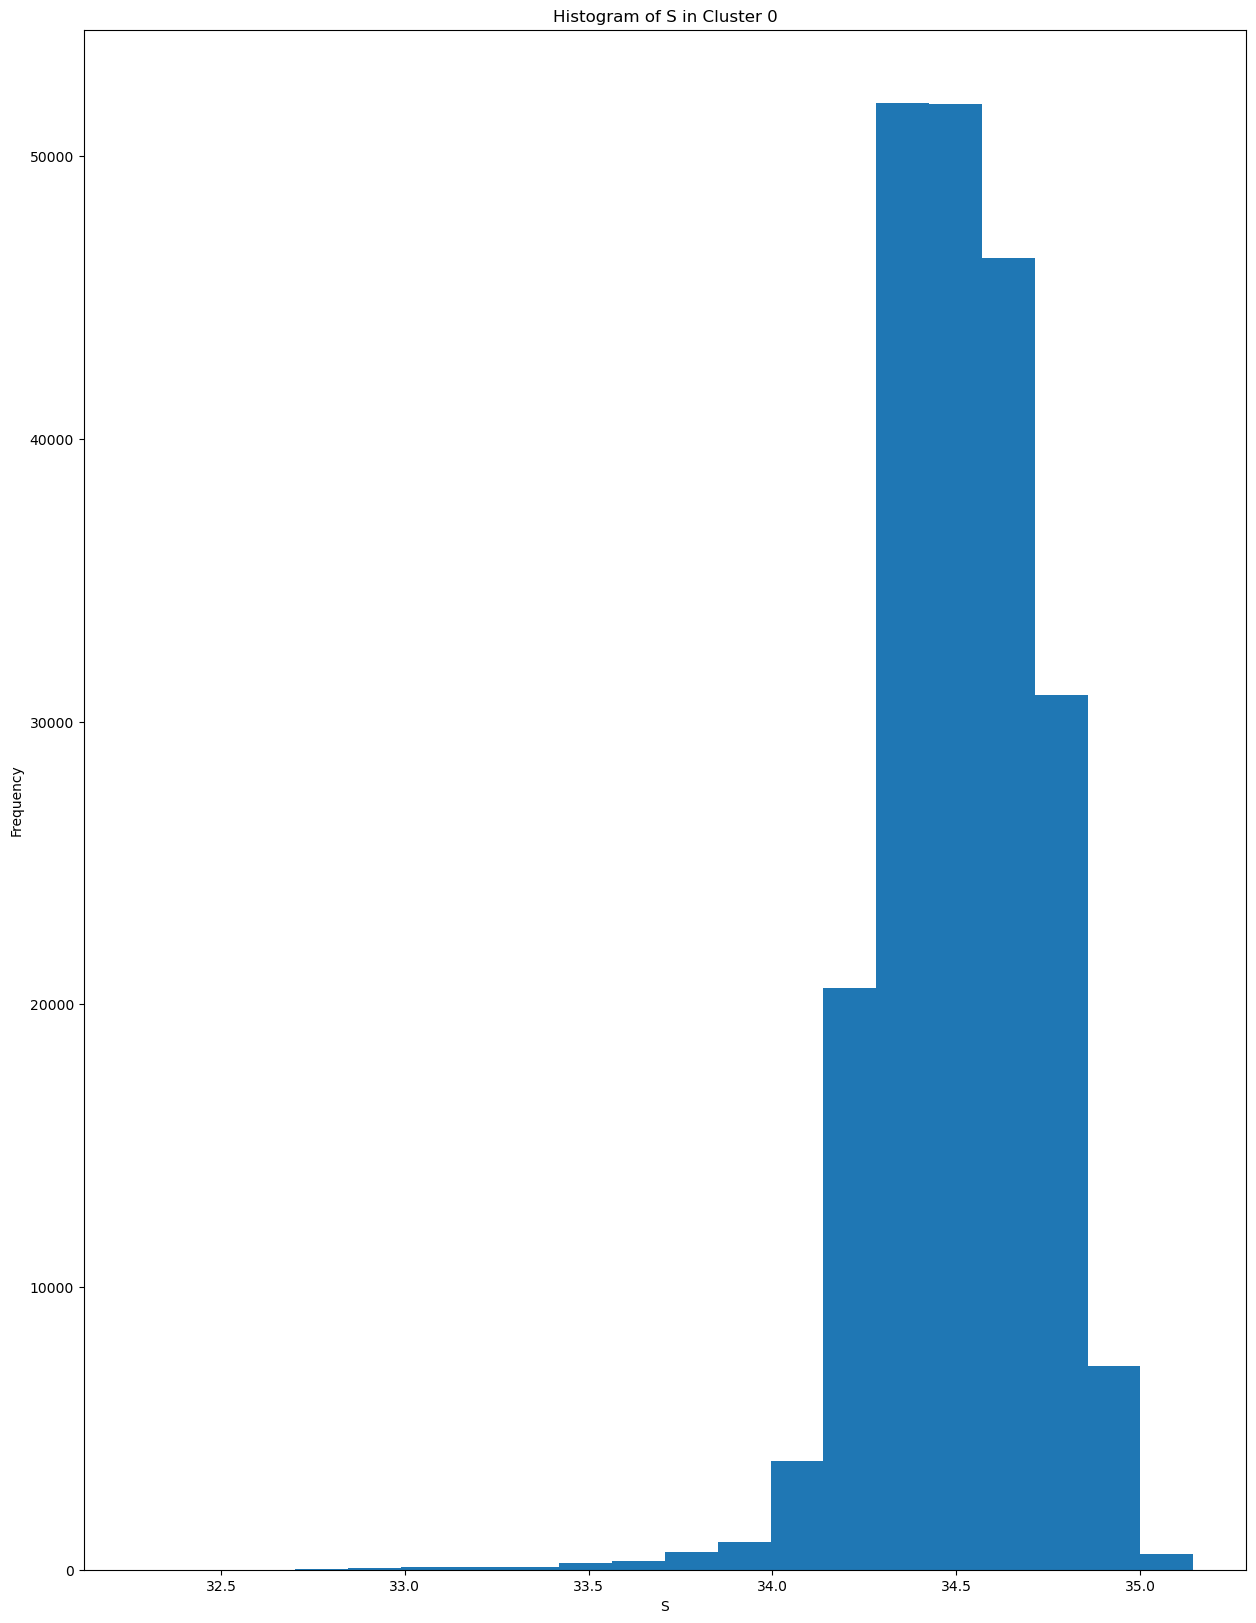

In [56]:
plt.hist(cluster_0_data['S'], bins=20)
plt.xlabel('S')
plt.ylabel('Frequency')
plt.title('Histogram of S in Cluster 0')
plt.show()

                   S              T        log_eps         log_N2  \
count  235196.000000  235196.000000  235196.000000  235196.000000   
mean       33.419258      -1.657869      -8.713804      -4.382382   
std         0.906582       0.270789       0.645716       0.813065   
min        24.054300      -2.251600     -10.737900     -10.442700   
25%        33.010000      -1.790000      -9.111400      -4.814300   
50%        33.674000      -1.733600      -8.924600      -4.170900   
75%        34.102100      -1.630600      -8.548300      -3.825500   
max        35.749300       3.456300      -6.197800      -2.608300   

                dTdz           dSdz   Cluster          depth        profile  \
count  235196.000000  235196.000000  235196.0  235196.000000  235196.000000   
mean        0.002348       0.015966       1.0      60.558729     743.478502   
std         0.008489       0.022313       0.0      86.460755    3157.868470   
min        -0.092800      -0.032500       1.0   -5318.000000  

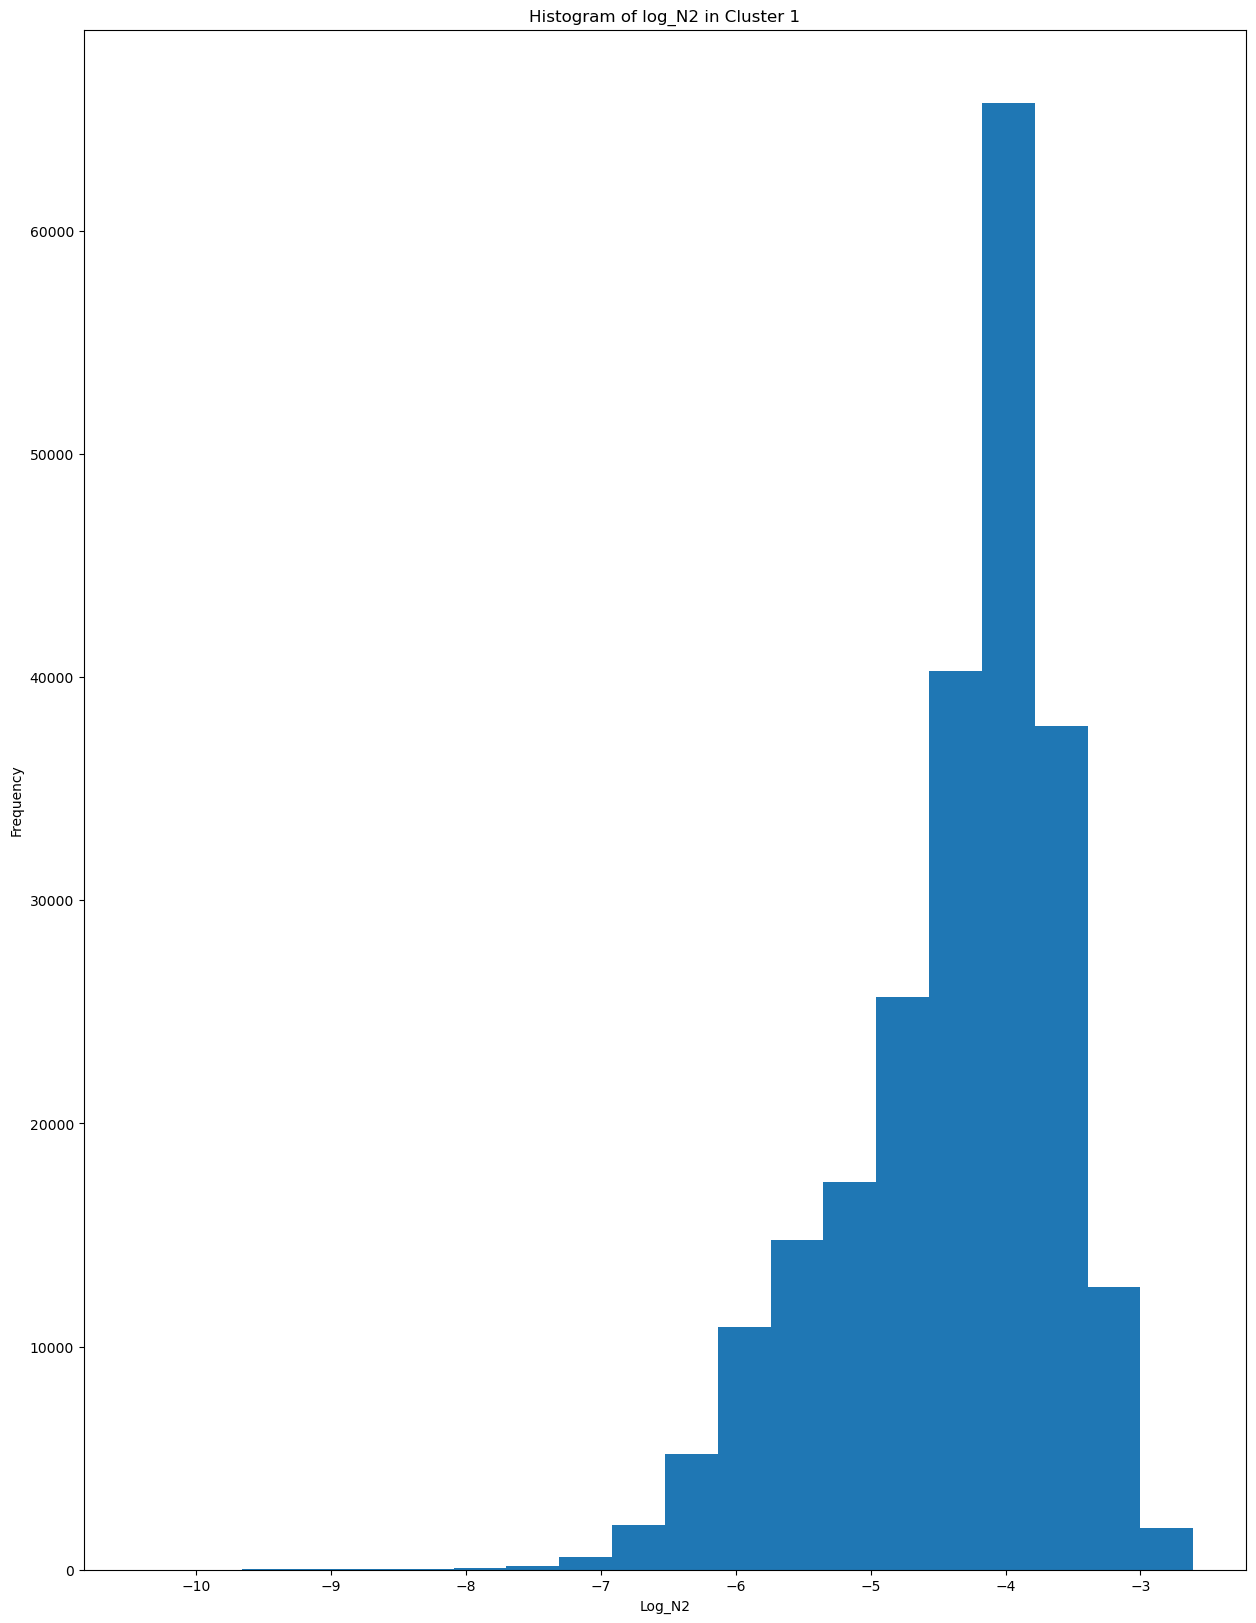

In [57]:
# Filter data for Cluster 1
cluster_1_data = merged_df[merged_df['Cluster'] == 1]

# Calculate descriptive statistics
cluster_1_statistics = cluster_1_data.describe()
print(cluster_1_statistics)

# Create a histogram for a specific feature (e.g., 'log_N2')
plt.hist(cluster_1_data['log_N2'], bins=20)
plt.xlabel('Log_N2')
plt.ylabel('Frequency')
plt.title('Histogram of log_N2 in Cluster 1')
plt.show()

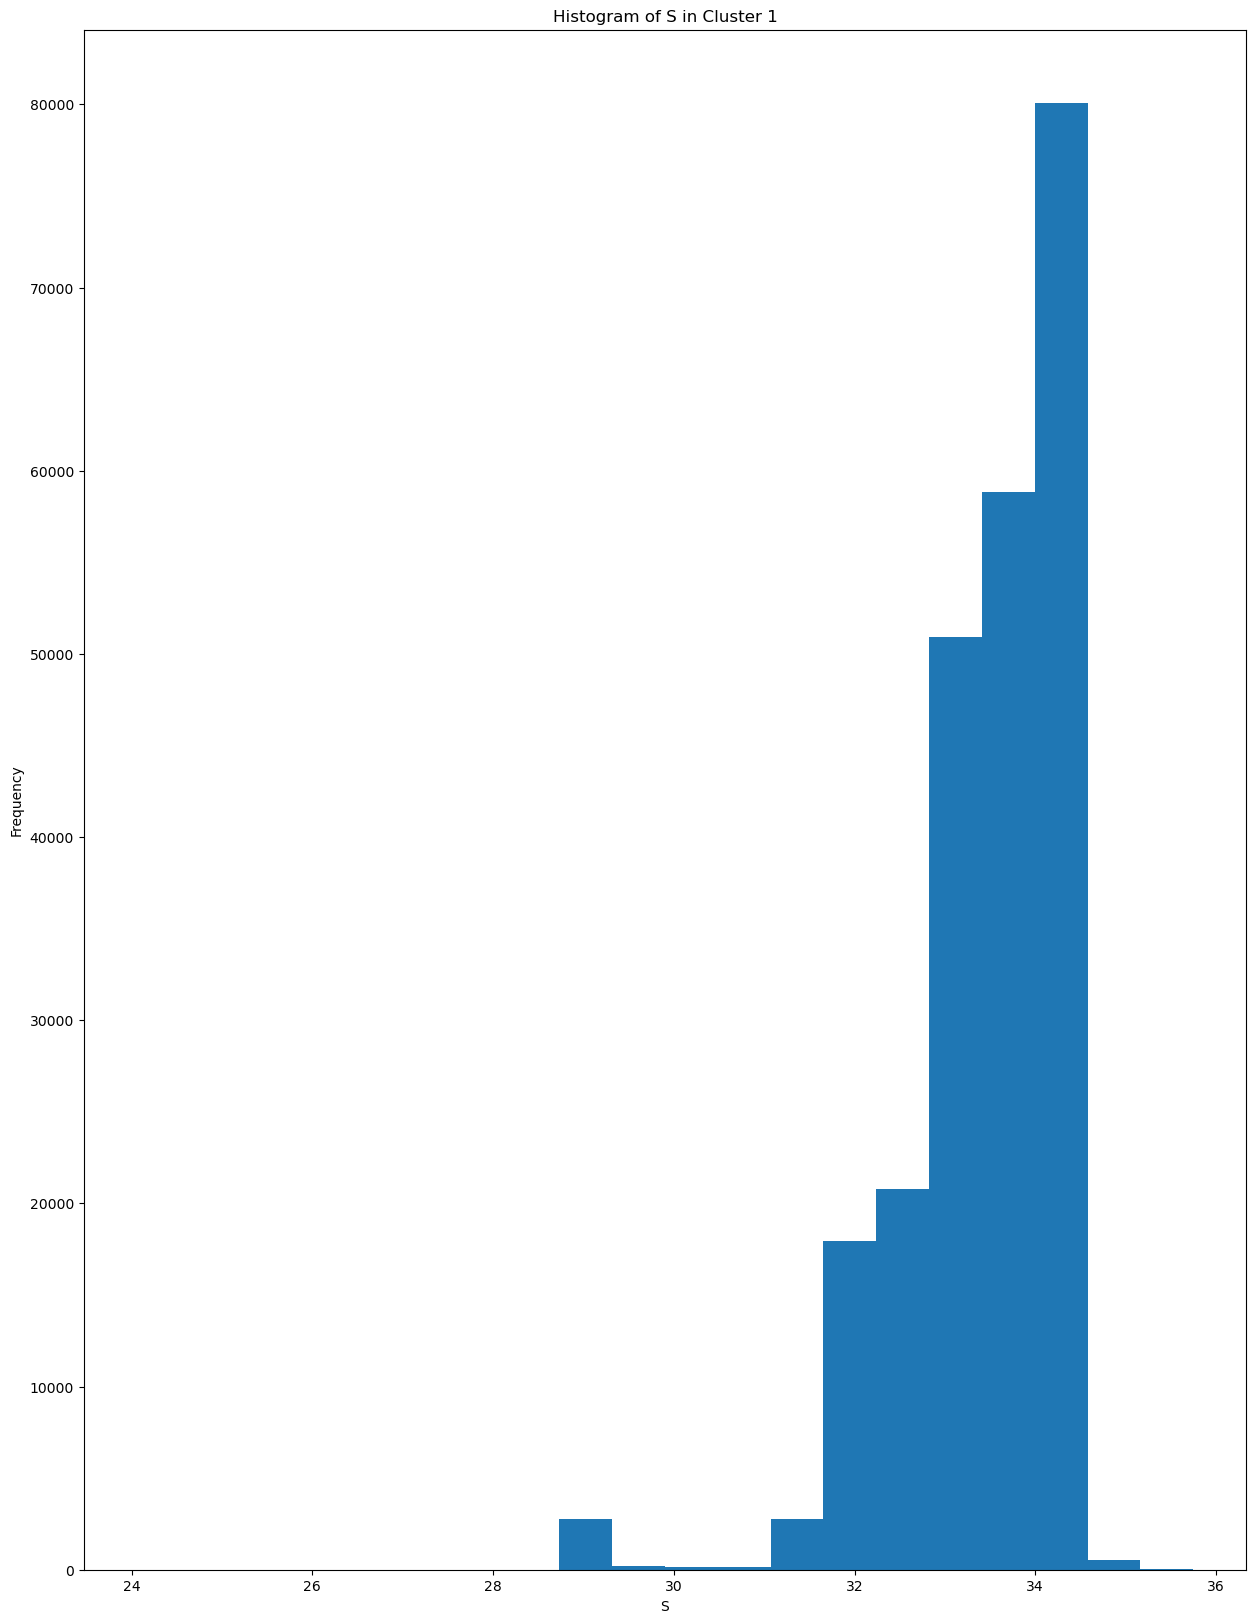

In [58]:
plt.hist(cluster_1_data['S'], bins=20)
plt.xlabel('S')
plt.ylabel('Frequency')
plt.title('Histogram of S in Cluster 1')
plt.show()

                   S              T        log_eps         log_N2  \
count  141594.000000  141594.000000  141594.000000  141594.000000   
mean       34.793812       3.325685     -10.010103      -5.665051   
std         0.284795       2.123494       0.381162       0.570812   
min        31.438300      -1.821000     -11.617000     -10.520300   
25%        34.656325       1.975025     -10.262900      -6.067800   
50%        34.812200       2.851700     -10.015300      -5.707100   
75%        34.935200       4.103700      -9.759100      -5.248500   
max        35.718500      10.325400      -8.462200      -3.335800   

                dTdz           dSdz   Cluster          depth        profile  \
count  141594.000000  141594.000000  141594.0  141594.000000  141594.000000   
mean        0.002650       0.000149       2.0   -3955.284973   14706.251802   
std         0.006537       0.001275       0.0    1674.109952   47462.064755   
min        -0.091700      -0.023400       2.0   -5904.000000  

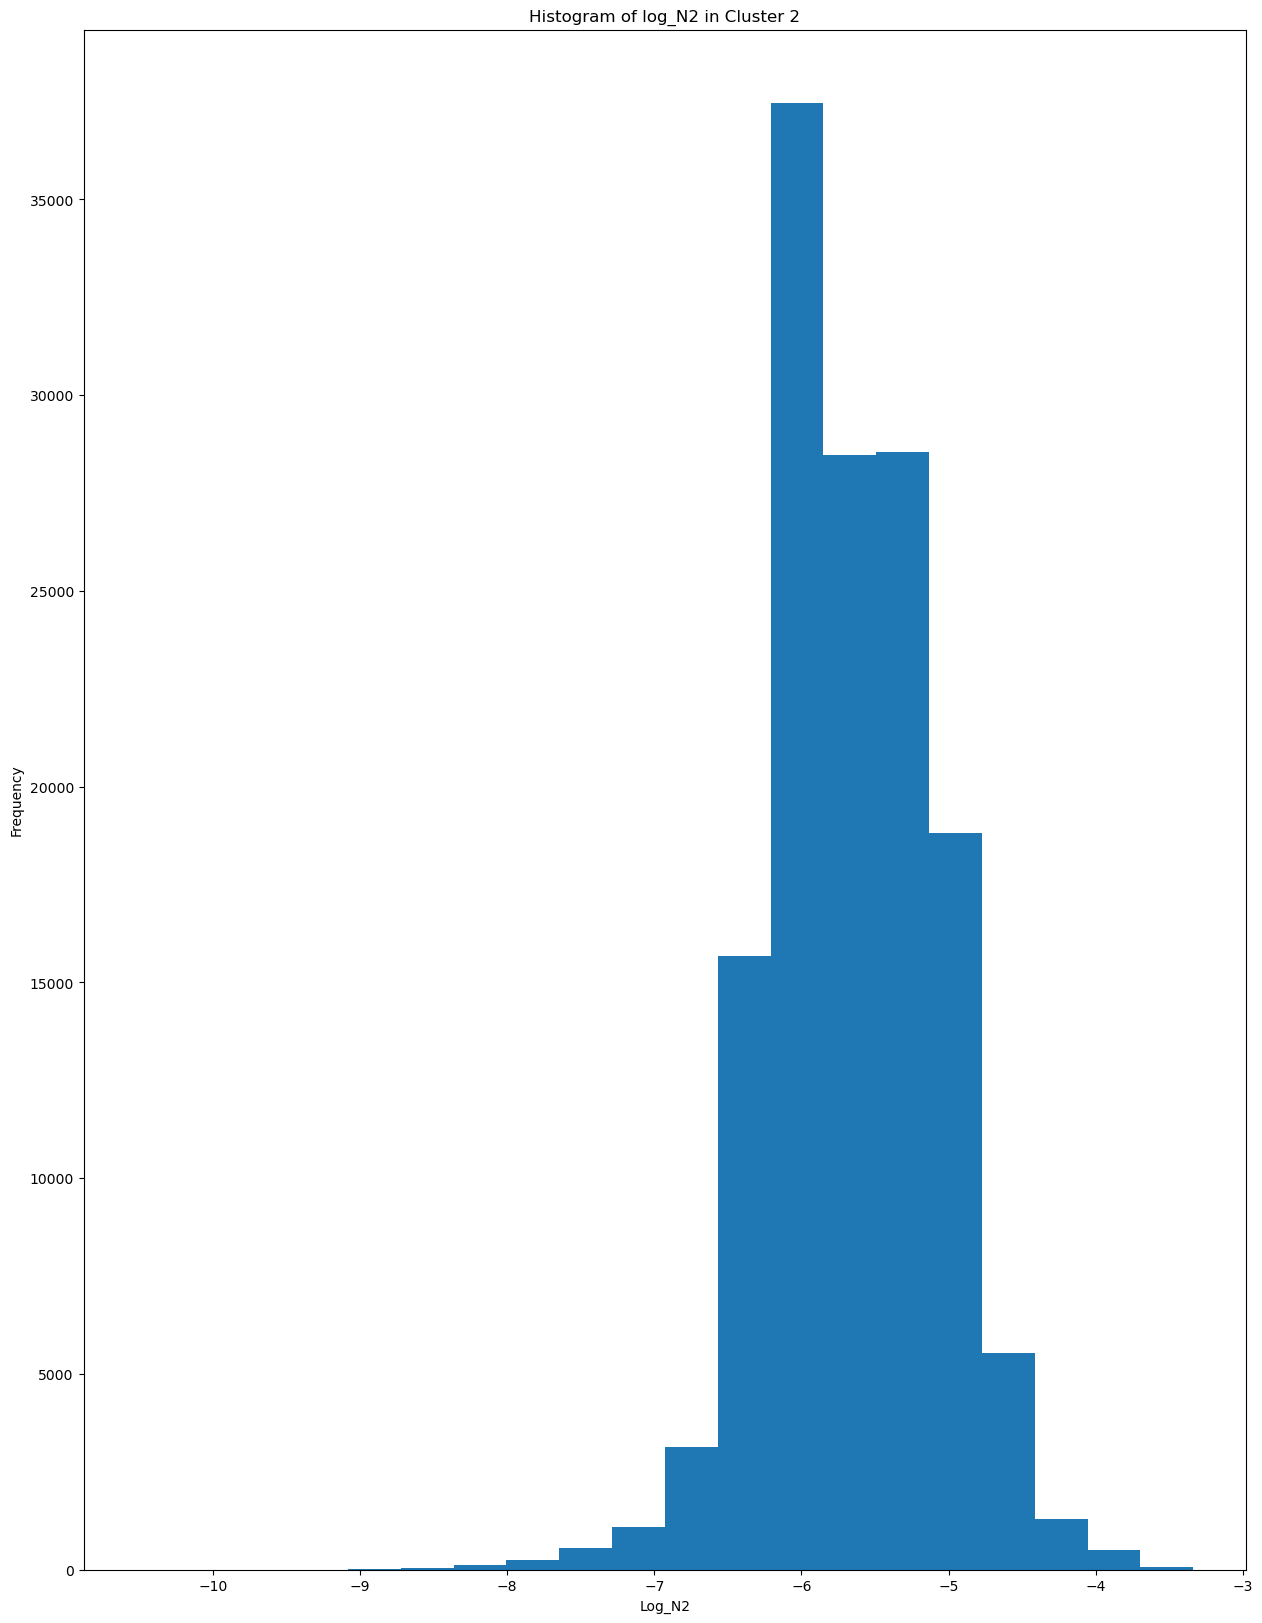

In [59]:
# Filter data for Cluster 2
cluster_2_data = merged_df[merged_df['Cluster'] == 2]

# Calculate descriptive statistics
cluster_2_statistics = cluster_2_data.describe()
print(cluster_2_statistics)

# Create a histogram for a specific feature (e.g., 'log_N2')
plt.hist(cluster_2_data['log_N2'], bins=20)
plt.xlabel('Log_N2')
plt.ylabel('Frequency')
plt.title('Histogram of log_N2 in Cluster 2')
plt.show()

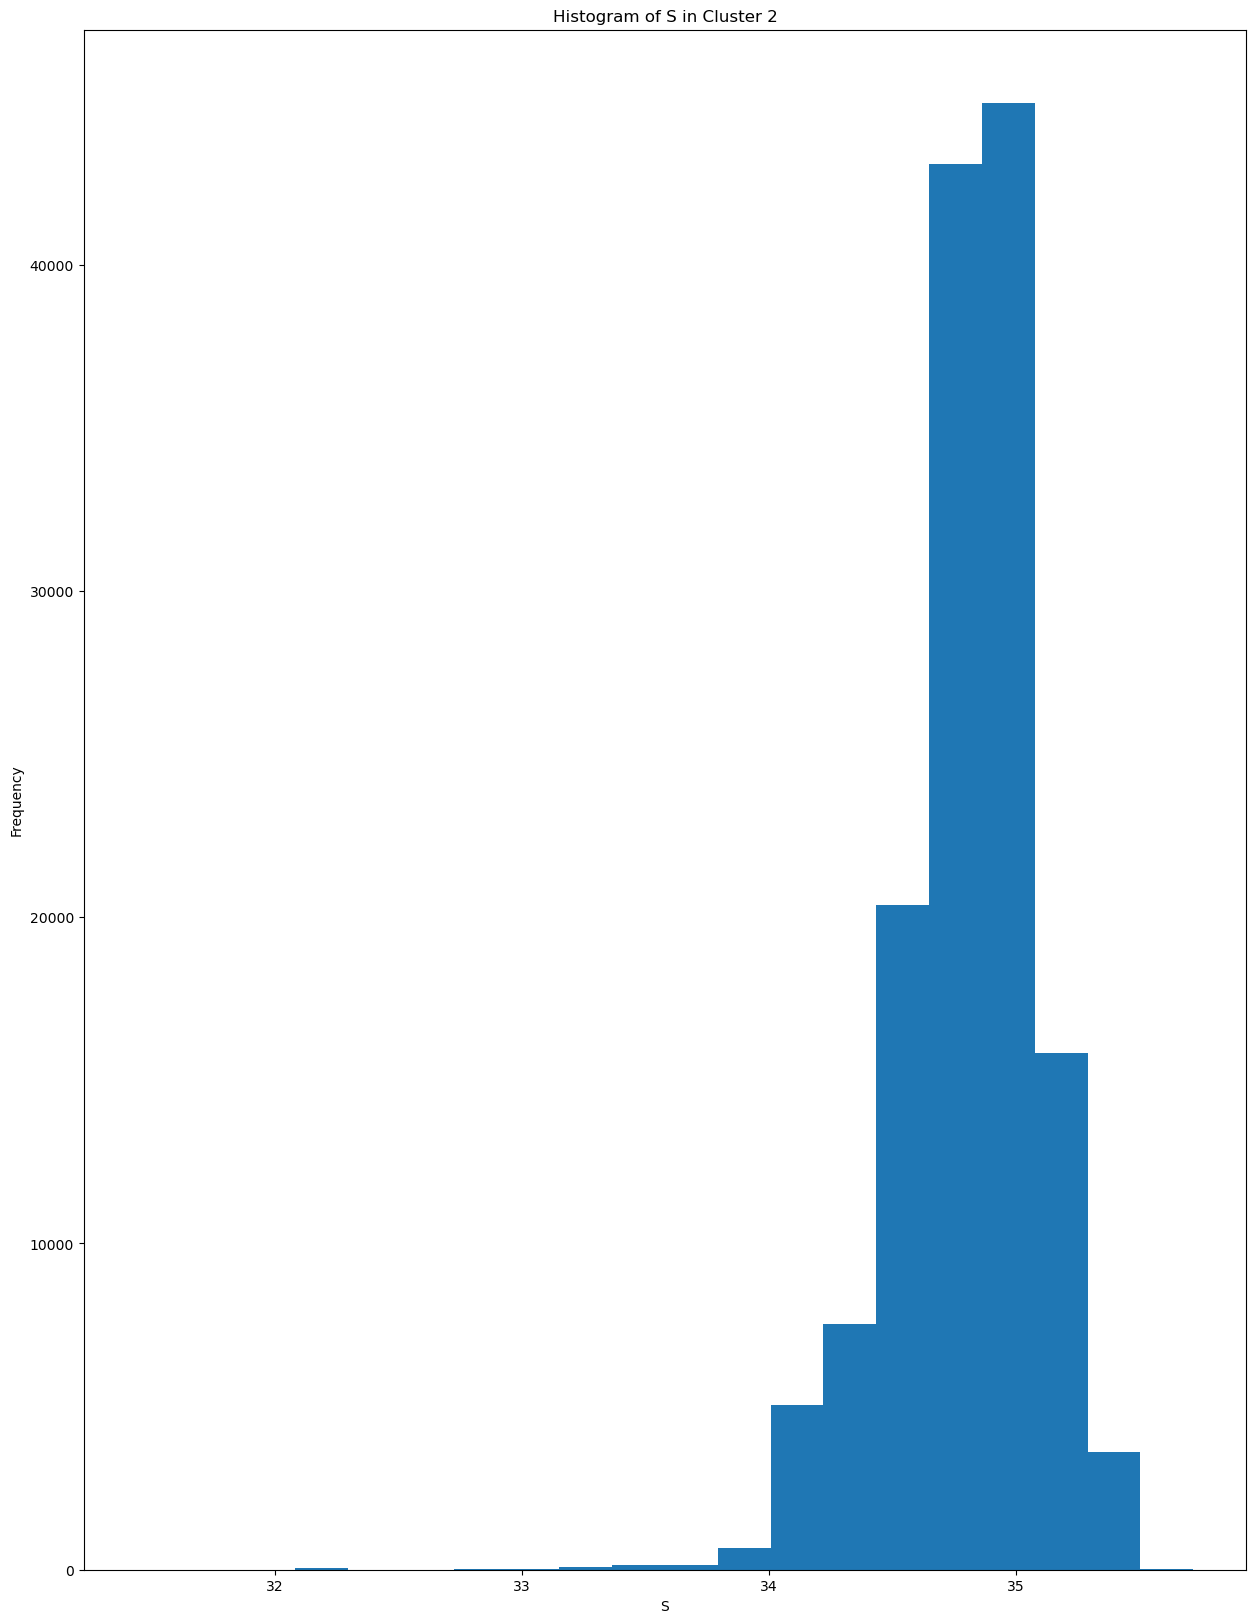

In [60]:
plt.hist(cluster_2_data['S'], bins=20)
plt.xlabel('S')
plt.ylabel('Frequency')
plt.title('Histogram of S in Cluster 2')
plt.show()

                   S              T        log_eps         log_N2  \
count  252744.000000  252744.000000  252744.000000  252744.000000   
mean       34.791038       1.708399      -8.981109      -5.581736   
std         0.200881       1.185565       0.420629       0.765571   
min        27.495000      -2.349700     -10.047200     -10.542100   
25%        34.756500       1.103700      -9.217400      -5.979500   
50%        34.823100       1.295200      -9.060000      -5.496700   
75%        34.884300       2.032900      -8.841400      -5.072300   
max        35.795400      10.320100      -6.198600      -2.968500   

                dTdz           dSdz   Cluster          depth        profile  \
count  252744.000000  252744.000000  252744.0  252743.000000  252743.000000   
mean        0.002193       0.000869       3.0    -321.447639    4317.264233   
std         0.007712       0.002007       0.0    1471.518912   24686.223632   
min        -0.093000      -0.059500       3.0   -5904.000000  

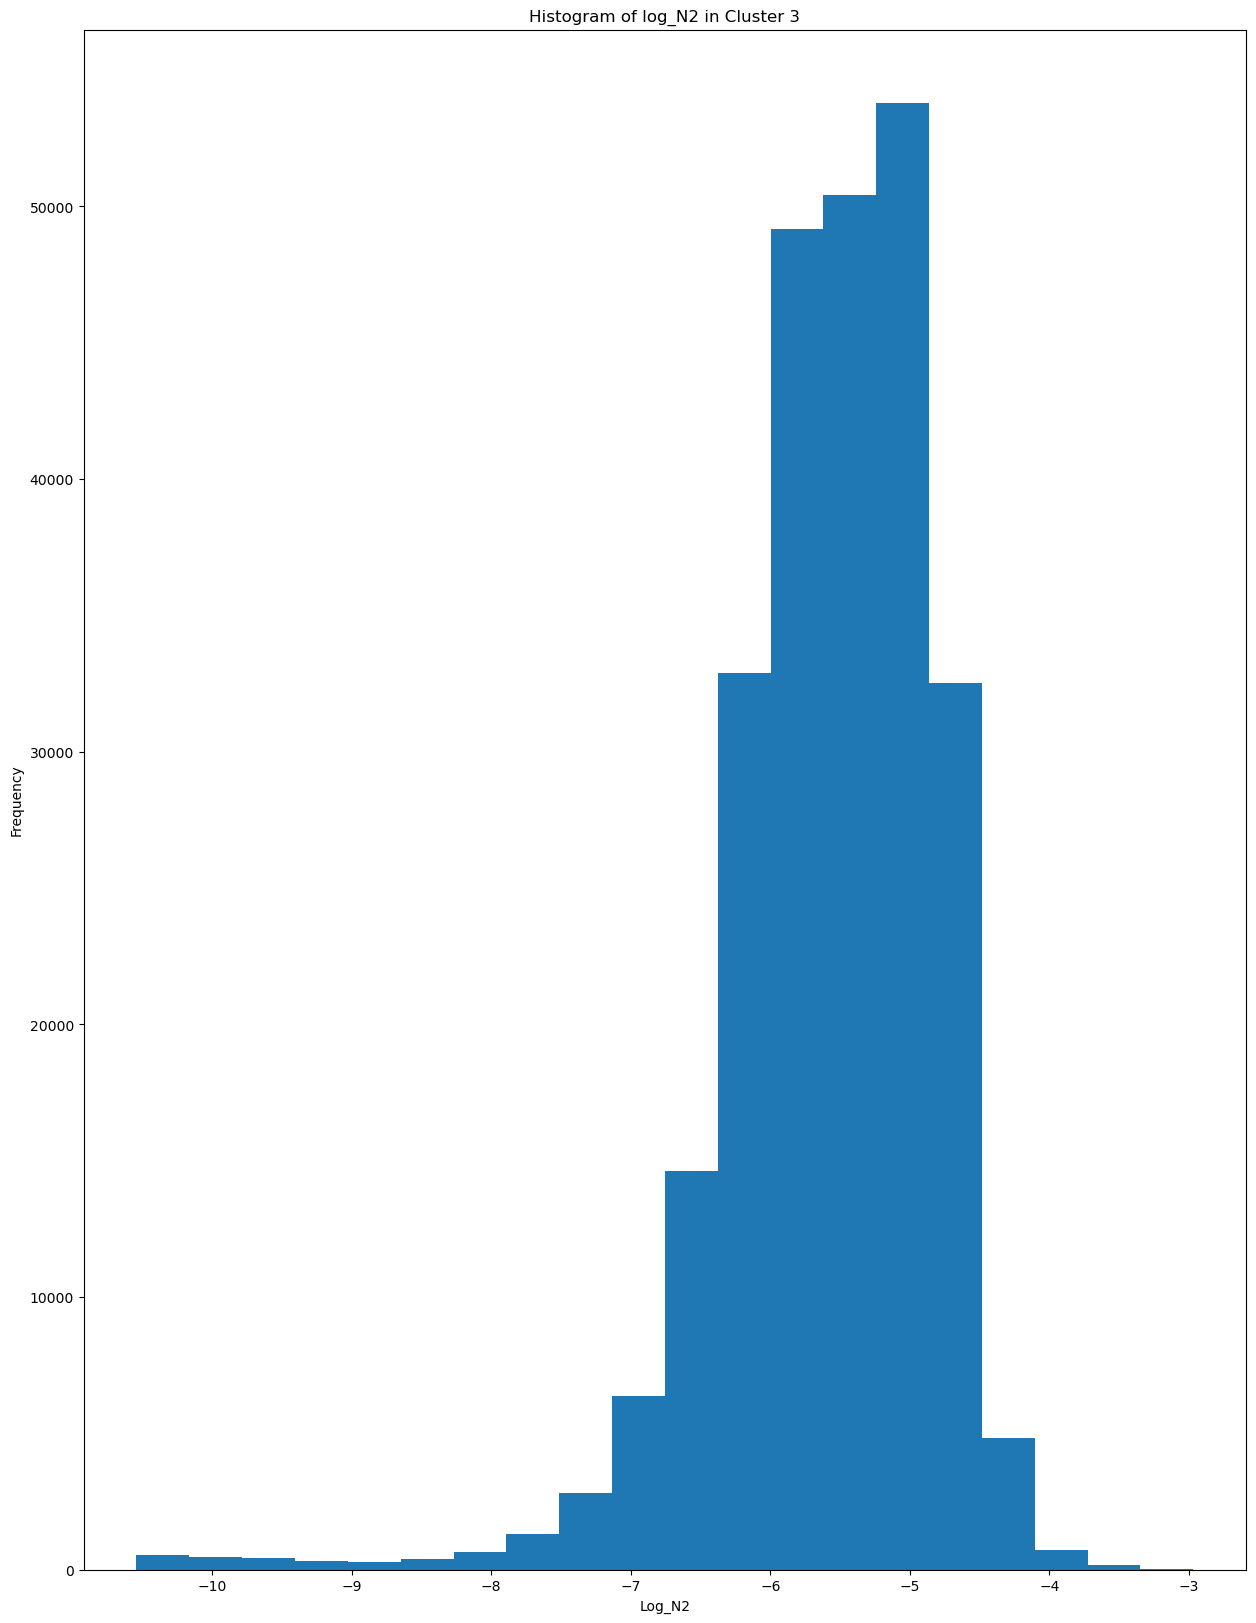

In [61]:
# Filter data for Cluster 3
cluster_3_data = merged_df[merged_df['Cluster'] == 3]

# Calculate descriptive statistics
cluster_3_statistics = cluster_3_data.describe()
print(cluster_3_statistics)

# Create a histogram for a specific feature (e.g., 'log_N2')
plt.hist(cluster_3_data['log_N2'], bins=20)
plt.xlabel('Log_N2')
plt.ylabel('Frequency')
plt.title('Histogram of log_N2 in Cluster 3')
plt.show()

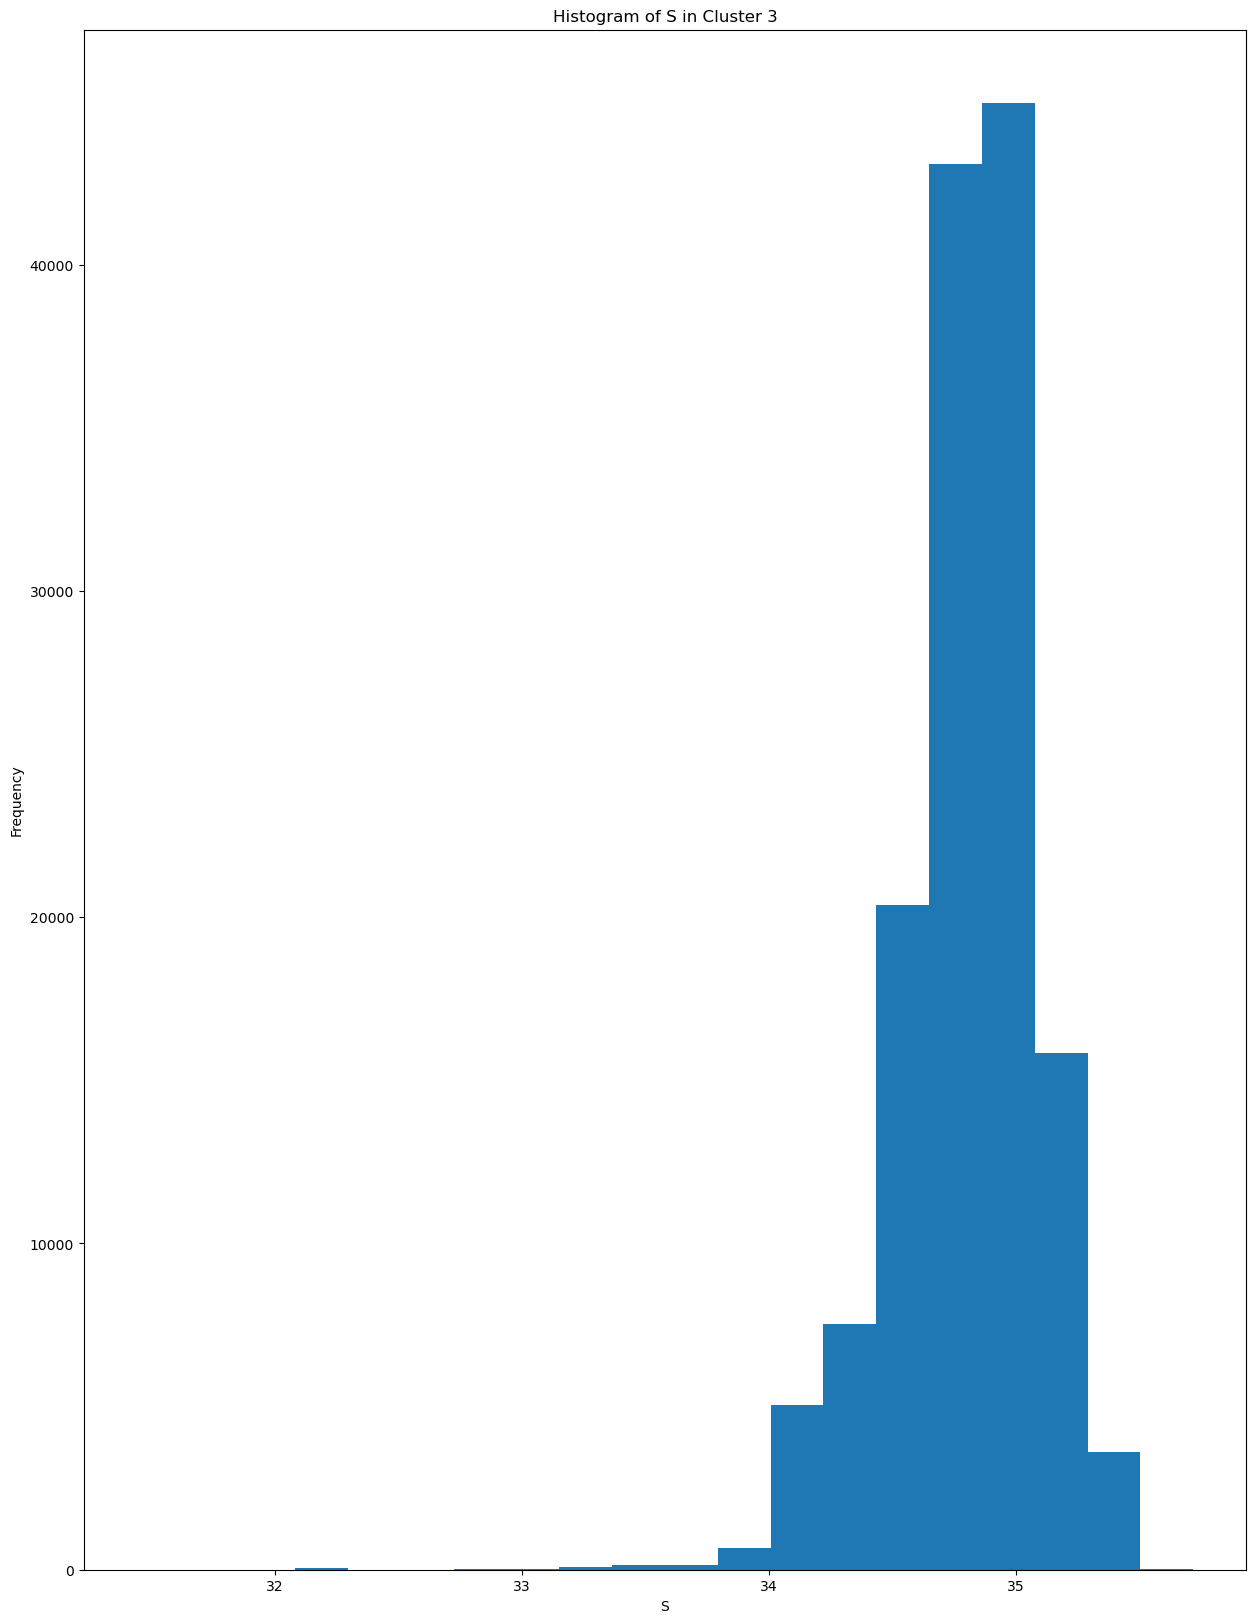

In [62]:
plt.hist(cluster_2_data['S'], bins=20)
plt.xlabel('S')
plt.ylabel('Frequency')
plt.title('Histogram of S in Cluster 3')
plt.show()

## Spatial variation of clusters

/var/folders/nn/7hvkdmmn3c15btn2lqvyf2800000gq/T/ipykernel_1093/3559511010.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(clusters))


AttributeError: module 'cartopy.crs' has no attribute 'feature'

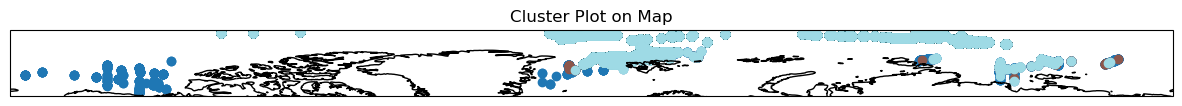

In [51]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

# Assuming you have a DataFrame with 'Latitude', 'Longitude', and 'Cluster' columns
# Replace 'df' with your actual DataFrame

# Create a figure and axis with a specified projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Define a list of unique clusters
clusters = merged_df['Cluster'].unique()

# Define a colormap for clusters
colormap = plt.cm.get_cmap('tab20', len(clusters))

# Plot data points for each cluster
legend_handles = []
for cluster_id, color in zip(clusters, colormap.colors):
    cluster_data = merged_df[merged_df['Cluster'] == cluster_id]
    ax.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_id}', c=[color])
    legend_handles.append(Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster_id}', markerfacecolor=color, markersize=10))

# Customize the plot
ax.set_title('Cluster Plot on Map')
ax.coastlines()
ax.add_feature(ccrs.feature.BORDERS, linestyle=':')
ax.add_feature(ccrs.feature.LAND, edgecolor='black')

# Create a legend
ax.legend(handles=legend_handles, title='Clusters', loc='upper left')

# Show the map plot
plt.show()


In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

# Define the number of desired samples per degree of latitude
samples_per_degree = 1

# Group the DataFrame by latitude and longitude and sample 10 data points per degree of latitude
subsampled_df = merged_df.groupby(['latitude', 'longitude']).apply(lambda x: x.sample(samples_per_degree) if len(x) >= samples_per_degree else x)

# Reset the index to remove the hierarchical index
subsampled_df.reset_index(drop=True, inplace=True)

# Create a figure and axis with a specified projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Define a list of unique clusters
clusters = subsampled_df['Cluster'].unique()

# Define a colormap for clusters
colormap = plt.cm.get_cmap('tab20', len(clusters))

# Plot data points for each cluster
legend_handles = []
for cluster_id, color in zip(clusters, colormap.colors):
    cluster_data = subsampled_df[subsampled_df['Cluster'] == cluster_id]
    ax.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_id}', c=[color])
    legend_handles.append(Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster_id}', markerfacecolor=color, markersize=10))

# Customize the plot
ax.set_title('Cluster Plot on Map')
ax.coastlines()
ax.set_extent([0, 170, -70, 89], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')

# Create a legend
ax.legend(handles=legend_handles, title='Clusters', loc='upper left')

# Show the map plot
plt.show()


: 

In [55]:
merged_df.describe()

,S,T,log_eps,log_N2,dTdz,dSdz,Cluster,depth,profile,latitude,longitude
count,845340.000000,845340.000000,845340.000000,845340.000000,845340.000000,845340.000000,845340.000000,845339.000000,845339.000000,845339.000000,679539.000000
mean,34.337380,0.606709,-9.091946,-4.979352,0.010357,0.006545,1.146804,-702.816202,4148.500090,65.505845,42.629696
std,0.777493,2.141285,0.633962,0.891124,0.017524,0.013679,0.830494,1813.350344,24258.521196,43.785650,50.189503
min,24.054300,-2.349700,-11.617000,-10.542100,-0.093000,-0.059500,0.000000,-5904.000000,0.000000,-64.344500,-175.291500
25%,34.164100,-1.523300,-9.310500,-5.625900,0.000100,0.000100,0.000000,26.000000,175.000000,80.695400,0.316000
50%,34.598200,0.772000,-9.084200,-4.862500,0.002800,0.002500,1.000000,108.000000,447.000000,86.703700,15.281800
75%,34.820800,1.619400,-8.853200,-4.333600,0.017700,0.007100,2.000000,196.000000,1158.000000,87.727100,95.722400
max,35.795400,10.325400,-6.197800,-2.608300,0.113300,0.166600,2.000000,1400.172500,170572.000000,89.240000,162.525100
